# Notes for project

## Construction of Differentiation Matrix

The idea here is that we will have $\psi(x,t) \mapsto \vec{\psi}(t)$, then we want to construct a matrix:
$D_{xx}$ such that 

$$\left(D_{xx} \vec{\psi}(t)\right)_k = \frac{\partial^2 \psi}{\partial x^2} (x_k,t)$$

For the $k$'th $x$ position.

First we construct $x$ nodes: $x \in \left[-L,L\right]$, using $M$ nodes:

$$x_k = -L + kh, \quad h = \frac{2L}{M}, \quad k = 0, 1, ..., M$$

For the iterior nodes $(x_{1}, ..., x_{M-1})$ we have 

$$\frac{1}{h^2}\left[\psi(x_{k+1},t) - 2 \psi(x_k,t) + \psi(x_{k-1},t)\right] = \frac{\partial^2 \psi}{\partial x^2} (x_k,t) + O(h^2)$$

Corresponding to a row in $D_{xx}$ of $\left[1,-2,1\right]$.

Now we need to be concerned with the ends.  Without loss of generality, consider $x_0$.  We want to find coefficients $a,b,c,d$ such that:

$$af(x + 3h) + bf(x + 2h) + cf(x + h) + d f(x) = f''(x) + O(h^2)$$

Taylor expanding gives the following system:

$$\begin{split}
(a + b + c + d) f(x) & = 0 \\
(3a + 2b + c) hf'(x) & = 0 \\
(9a + 4b + c) \frac{h^2}{2} f''(x) & = f''(x) \\
(27a + 8b + c) \frac{h^3}{6} f^{(3)}(x) & = 0
\end{split}$$

We can find the coefficients $a, b, c, d$ by solving the following system and scaling by $\frac{2}{h^2}$:

$$\begin{bmatrix} 
1 & 1 & 1 & 1 \\
3 & 2 & 1 & 0 \\
9 & 4 & 1 & 0 \\
27 & 8 & 1 & 0 
\end{bmatrix} \begin{bmatrix} a \\ b \\ c \\ d \end{bmatrix} = 
\begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}$$

In [4]:
import numpy as np
import numpy.linalg as la
A = np.matrix([[1,1,1,1],[3,2,1,0],[9,4,1,0],[27,8,1,0]])
e3 = np.matrix([0,0,1,0]).transpose()

coefs = la.solve(A,e3)
print(coefs)

print(np.matmul(A,coefs))

[[-0.5]
 [ 2. ]
 [-2.5]
 [ 1. ]]
[[ 0.0000000e+00]
 [-4.4408921e-16]
 [ 1.0000000e+00]
 [-4.4408921e-16]]


Therefore we have the first row of $D_{xx}$ is $\left[1, -\frac{5}{2}, 2, -\frac{1}{2}\right]$

And for the last row we negate every other column of the matrix $A$ above, and so the last row of $D_{xx}$ is 
$\left[\frac{1}{2}, -2, \frac{5}{2}, -1\right]$.  Therefore the differentiation matrix is 

$$D_{xx} = \frac{2}{h^2}\begin{bmatrix} 
1 & -\frac{5}{2} & 2 & -\frac{1}{2} & 0 & ... & & 0 \\
1 & -2           & 1 &       0      & 0 & ... & & 0 \\
0 & 1           &  -2 &     -1      & 0 & ... & & 0 \\
\vdots & & &  \ddots  & \ddots & \ddots & & \vdots\\
0 & ... & & & 1 & -2 & 1 & 0 \\
0 & ... & & & \frac{1}{2} & -2 & \frac{5}{2} & -1 
\end{bmatrix}$$

Which is second order accurate.

## One dimensional wave equation with reflecting boundary

$$\begin{split}
\frac{\partial^2 \psi}{\partial x^2} = \frac{\partial^2 \psi}{\partial t^2}, \quad 
x \in \left[-1,1\right], \quad t \in \left[0,T\right] \\
\psi(1,t) = \psi(-1,t) = 0 \quad \text{(Reflecting Boundary)} \\
\psi(x,0) = f(x), \quad \frac{\partial \psi}{\partial t} (x,0) = g(x) \quad \text{(Initial Conditions)}
\end{split}$$

Discretization:

$M$ will be the number of $x$ nodes.  $x_k = -1 + hk$ where $h = \frac{2}{M}$, and $k = 0, 1, ..., M$.  We will let 
$\vec{\psi}(t) = \psi(\vec{x},t) \in \mathbb{R}^{M+1}$.

$D_{xx} \in \mathbb{R}^{(M+1)\times (M+1)}$ will be constructed as above.  We will then be solving:

$$\frac{d^2}{dt^2} \vec{\psi}(t) = D_{xx} \vec{\psi}(t)$$

At each stage: $\psi_0(t)$ and $\psi_M(t)$ will be set to zero (boundary condition), and the initial conditions are 
$\vec{\psi(0)} = \vec{f} = f(\vec{x})$, and $\frac{d}{dt} \vec{\psi}(0) = \vec{g} = g(\vec{x})$

Time will be discretized into $N$ nodes so that $t_j = j\tau$ where $\tau = \frac{T}{N}$ and $j = 0, 1, ... N$.  
We will solve the ODE above using the Stormer-Verlet Method:

$$\begin{split}
\vec{\psi}(0) = \vec{f}, \quad \frac{d}{dt} \vec{\psi}(0) = \vec{g} \\
\vec{\psi}(t_1) = \vec{f} + \tau \vec{g} + \frac{\tau^2}{2} D_{xx} \vec{f} \\
\vec{\psi}(t_{j+1}) = 2\vec{\psi}(t_j) - \vec{\psi}(t_{j-1}) + \tau^2 D_{xx}\vec{\psi}(t_j) & \quad j > 1
\end{split}$$

For simplicity, we will let $g(x) \equiv 0$ and 

$$f(x) = \begin{cases}
\frac{1}{\epsilon^4}(x-\epsilon)^2(x + \epsilon)^2 & |x| \leq \epsilon \ll 1 \\
0 & |x| > \epsilon
\end{cases}$$

Consider that we then have 

$$\vec{psi}_{j+1} = 2\vec{\psi}_j - \vec{\psi}_{j-1} + \tau^2 D_{xx} \vec{\psi}_{j} = 
2\vec{\psi}_j - \vec{\psi}_{j-1} + \frac{2\tau^2}{h^2} A \vec{\psi}_j$$

Then clearly the characteristic velocity is $\frac{h}{\sqrt{2}\tau}$

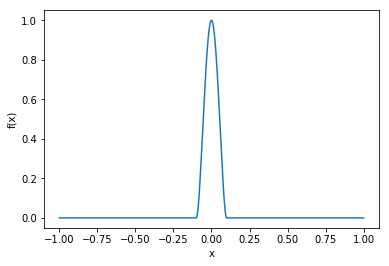

Wave Speed: 1.131370849898477


MovieWriter ffmpeg unavailable.


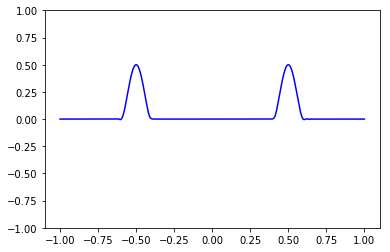

In [18]:
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.animation as ani

# setup

xspan = [-1,1]
tspan = [0,2.5]
eps = 1.0/10

M = 1000
N = 2000
numImSkip = 20
x = np.linspace(xspan[0],xspan[1],M+1)
t = np.linspace(tspan[0],tspan[1],N+1)


# initial condition
def f(x,eps):
    result = np.power(np.power(x,2) - np.power(eps,2),2)
    result[x < -eps] = 0
    result[x > eps] = 0
    result = np.divide(result,np.power(eps,4))
    return result

# testing f(x)

plt.figure()
plt.plot(x,f(x,eps))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# building the differentiation matrix
def buildDiffmat2(x):
    """Building the second differentiation matrix D_{xx}
    Input: only x - M + 1 vector
    Output: M + 1 x M + 1 differentiation matrix
    Note this function assumes the x nodes are equally spaced!
    """
    size = len(x)    # M + 1
    h = x[1] - x[0]
    Dxx = np.diagflat(-2*np.ones([size,1]))    # main diagonal
    Dxx += np.diagflat(np.ones([size-1,1]),1) + np.diagflat(np.ones([size-1,1]),-1)    # subdiagonals
    Dxx[0,:4] = [1, -2.5, 2, -0.5]             # fix first and last rows
    Dxx[-1,-4:] = [0.5, -2, 2.5, -1]
    # trying with robin boundary conditions
    #alpha = 1/2
    #Dxx[0,:4] = [-12*alpha/22,  -19/22, 26/22, -7/22]
    #Dxx[-1,-4:] = [-7/22, 26/22, -19/22, -12*alpha/22]
    Dxx *= 2/np.power(h,2)
    return Dxx
    
# ode function
def fun(t,psi,params):
    Dxx = params
    return np.matmul(Dxx,psi)

# verlet integration
def verlet(t,x,fun,psiInit,params):
    """Verlet integration
    """
    tau = t[1] - t[0]        # t spacing
    psi = np.zeros([len(t),len(x)])
    psi[0,:] = psiInit[0]       # initial condition
    
    # starting step 
    psi[1,:] = psiInit[0] + tau * psiInit[1] + np.power(tau,2)/2 * fun(t,psiInit[0],params)
    
    # iterating
    for j in range(1,len(t)-1):
        # main verlet step
        psi[j+1,:] = 2*psi[j,:] - psi[j-1,:] + np.power(tau,2) * fun(t,psi[j,:],params)
    return psi


# solution

# build differentiation matrix
Dxx = buildDiffmat2(x)

# integrate via verlet
psi = verlet(t,x,fun,[f(x,eps),np.zeros(len(x))],Dxx)

tau = t[1] - t[0]
h = x[1] - x[0]
speed = h/(np.sqrt(2)*tau)
print("Wave Speed: " + str(speed))
fig = plt.figure()

ims = []
for i in range(0,N,numImSkip):
    im = plt.plot(x,psi[i,:],'b')
    plt.ylim([-1,1])
    ims.append([im[0]])

anim = ArtistAnimation(fig,ims,interval=10,blit=True)
anim.save("wave-ani.gif")

Clearly this simulates the 1D wave equation quite effectively.  I have also experimented with an artificial reflector placed about 1/3 of the way from $x = -1$.  Now on to the 2D case.

## 2D Case

For the 2D case we have the following:

$$\begin{split}
\nabla^2 \psi = \frac{\partial^2 \psi}{\partial t^2}, \quad \vec{x} = (x,y) \in \left[-1,1\right] \times \left[-1,1\right] =: \Omega\\
\left.\psi(\vec{x},t)\right|_{\partial \Omega} = 0 \\
\psi(\vec{x},0) = f(\vec{x}), \quad \frac{\partial \psi}{\partial t}(\vec{x},t) = g(\vec{x})
\end{split}$$

The we can use the above discretization in the 2 dimensions.  This will give us $x_k = -1 + k\frac{2}{M}$, and 
$y_l = -1 + l\frac{2}{M}$, where $k,l = 0, 1, ..., M$.

As above, we can then construct $\psi(\vec{x},t) \to \Psi(t)$, where $\Psi(t) \in \mathbb{R}^{M+1\times M+1}$

We will then be solving the problem of 

$$\frac{d^2}{dt^2} \Psi(t) = D_{xx} \Psi(t) + \Psi(t) D_{yy}^T, \quad \Psi(0) = F = f(\vec{x}), \quad 
\frac{d}{dt} \Psi(t) = G = g(\vec{x})$$

Where both $D_{xx}$ and $D_{yy}$ are constructed as specified above.

For simplicity, we will have 

$$f(\vec{x}) = \begin{cases}\frac{1}{\epsilon^2} (||\vec{x}||^2 - \epsilon^2)^2 & ||\vec{x}|| \leq \epsilon \\
0 & ||\vec{x}|| > \epsilon \end{cases}, \quad g(x) \equiv 0$$

MovieWriter ffmpeg unavailable.


Speed = 1.4213201631890462


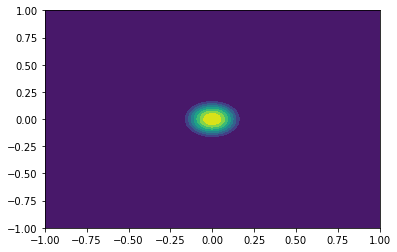

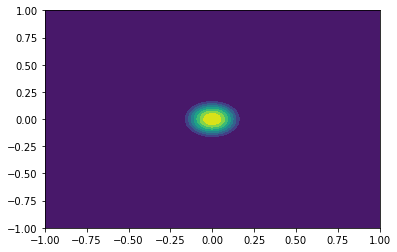

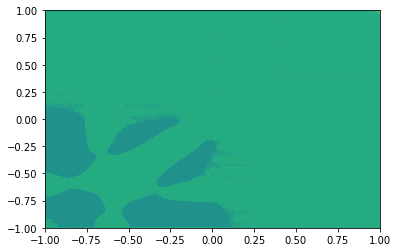

In [30]:
import numpy.linalg as la

# setup
xspan = [-1,1]
yspan = [-1,1]
tspan = [0,2]

# for initial condition
eps = 1.0/5

M = 200    # number x/y nodes
N = 400    # number t nodes

# construction 
x = np.linspace(xspan[0],xspan[1],M)
y = np.linspace(yspan[0],yspan[1],M)

# construct meshed grids of x and y values
[xmat,ymat] = np.meshgrid(x,y)
xarr = [xmat,ymat]      # array of vectors representing position

# initial condition
def f(x,eps):
    # extract x and y
    xx = x[0]
    yy = x[1]
    
    # build function
    result = np.power(xx,2) + np.power(yy,2) - np.power(eps,2)
    result = np.divide(np.power(result,2),np.power(eps,2))
    
    # enforce zero outside range
    result[np.power(xx,2) + np.power(yy,2) > eps**2] = 0
    
    return result

#z = f([xmat,ymat],eps)
#plt.contourf(xmat,ymat,z)

Dxx = buildDiffmat2(x)
Dyy = buildDiffmat2(y)
Dyyt = Dyy.T

# ode function
def fun(t,psi,params):
    Dxx = params[0]
    Dyyt = params[1]
    return np.matmul(Dxx,psi) + np.matmul(psi,Dyyt)

# adjusting verlet method for 2d
def verlet2d(fun,tspan,psiInit,params):
    
    N = params[2]    # number t nodes 
    M = params[3]    # number x/y nodes
    # construct time vector
    t = np.linspace(tspan[0],tspan[1],N)
    tau = t[1] - t[0]        # t spacing
    
    dims = np.shape(psiInit[0])
    dims = np.insert(dims,0,N)
        
    psi = np.zeros(dims)
    psi[0,:,:] = psiInit[0]       # initial condition
    
    # starting step 
    psi[1,:,:] = psiInit[0] + tau * psiInit[1] + np.power(tau,2)/2 * fun(t,psiInit[0],params)
    
    # iterating
    for j in range(1,len(t)-1):
        # main verlet step
        psi[j+1,:,:] = 2*psi[j,:,:] - psi[j-1,:,:] + np.power(tau,2) * fun(t,psi[j,:,:],params)
    return psi

psiInit = [f(xarr,eps),np.zeros(np.shape(xmat))]
psi = verlet2d(fun,tspan,psiInit,[Dxx,Dyyt,N,M])


h = x[1] - x[0]
tau = tspan[1]/N
speed = h/(np.sqrt(2)*tau)
print("Speed = " + str(speed))

fig,ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.contourf(xmat,ymat,psi[i,:,:])
    
interval = 0.0001

anim = ani.FuncAnimation(fig,animate,N,interval=interval*1e+3,blit=False,repeat=True)
anim.save("wave-2d.gif")

plt.figure()
plt.contourf(xmat,ymat,psi[0,:,:])
plt.figure()
plt.contourf(xmat,ymat,psi[-1,:,:])
plt.show()


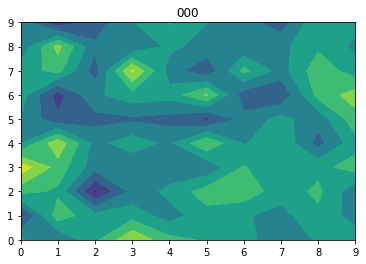

In [4]:
DATA = np.random.randn(800).reshape(10,10,8)


fig,ax = plt.subplots()

def animate(i):
       ax.clear()
       ax.contourf(DATA[:,:,i])
       ax.set_title('%03d'%(i)) 

interval = 2#in seconds     
anim = ani.FuncAnimation(fig,animate,5,interval=interval*1e+3,blit=False)

## Absorbing boundary conditions

First we experiment with the following boundary condition in 1D:

$$\frac{\partial \psi}{\partial x} = \alpha \psi$$

Which is a form of a Robin Boundary Condition.  To this end we wish to find coefficients such that 

$$a f'(x) + bf(x + h) + cf(x + 2h) + df(x + 3h) = \frac{h^2}{2} f''(x) + (h^4)$$

In [3]:
import numpy as np
import numpy.linalg as la

A = np.matrix([[0,1,1,1],[1,1,2,3],[0,1,4,9],[0,1,8,27]])
print(A)

b = np.array([0,0,1,0])
print(b)

sol = la.solve(A,b)
print(sol*22)

A2 = np.matrix([[0,1,1,1],[1,-1,-2,-3],[0,1,4,9],[0,-1,-8,-27]])
print(A2)

sol2 = la.solve(A2,b)
print(sol*22)

[[ 0  1  1  1]
 [ 1  1  2  3]
 [ 0  1  4  9]
 [ 0  1  8 27]]
[0 0 1 0]
[-12. -19.  26.  -7.]
[[  0   1   1   1]
 [  1  -1  -2  -3]
 [  0   1   4   9]
 [  0  -1  -8 -27]]
[-12. -19.  26.  -7.]


So for a differentiation matrix with a robin condition we input this new solution in the first/last rows, multiply by $\frac{1}{11 h^2}$, then the first term ($-12$) is multiplied by $\alpha$ since $f' = \alpha f$

## Reflector Arrays

We will encode within the system a mirror which will reflect the wave.  This will act as the dish in the radar beam.

MovieWriter ffmpeg unavailable.


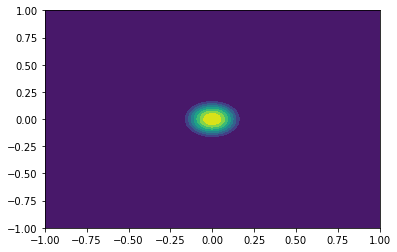

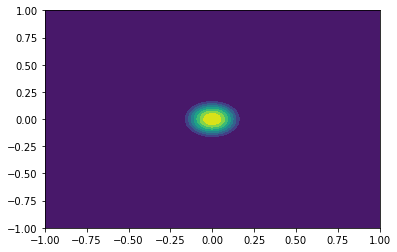

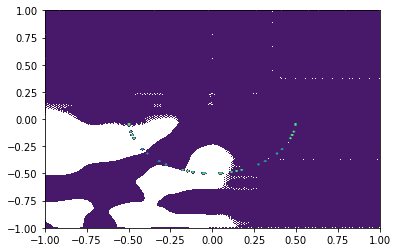

In [31]:
def fun(t,psi,params):
    """Function for wave with reflector build in
    """
    Dxx = params[0]
    Dyyt = params[1]
    arcfun = params[4]
    tol = params[5]
    xmat = params[6]
    ymat = params[7]
    psi[np.abs(arcfun(xmat,ymat)) < tol] = 0
    
    return np.matmul(Dxx,psi) + np.matmul(psi,Dyyt)

def arcfunCircle(x,y):
    tmp = np.power(x,2) + np.power(y,2) - 0.25
    tmp[y > 0] = 1
    return tmp

tol = 1e-3
params = [Dxx,Dyyt,N,M,arcfunCircle,tol,xmat,ymat]

psiInit = [f(xarr,eps),np.zeros(np.shape(xmat))]
psi = verlet2d(fun,tspan,psiInit,params)

fig,ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.contourf(xmat,ymat,psi[i,:,:])
    
interval = 0.0001

anim = ani.FuncAnimation(fig,animate,N,interval=interval*1e+3,blit=False,repeat=True)
anim.save("wave-2d-reflector.gif")

plt.figure()
plt.contourf(xmat,ymat,psi[0,:,:])
plt.figure()
plt.contourf(xmat,ymat,psi[-1,:,:])
plt.show()
